<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div> 
<div style="float:right;"><a href="../B/B.html"><img src="../data/B_nav.png" width="100" style="float:right;" alt="B"></a></div>
<div><h1>Numba</h1></div>
</div>

<br/>

<p>
This notebook gives a short introduction to the Python package Numba, which offers an open source <code>jit</code> (just-in-time) compiler that translates a subset of Python and NumPy code into fast machine code.       
</p> 

## Introduction

As described in the [main documentation](http://numba.pydata.org/), Numba translates Python functions to optimized machine code at runtime. The compiled numerical algorithms in Python can then approach the speeds of C or FORTRAN. Without the need of running a separate compilation step, Numba can be simply applied by adding decorators to the Python function. Since there are certain restriction on the Python code, we recommend to only use Numba for compiling functions that are performance-critical. Usually, this is only a small fraction of code. In the following we give a couple of illustrating example and refer to the [main documentation](http://numba.pydata.org/) for details.

<div class="alert alert-block alert-warning">
<strong>Note:</strong> Using numba can really make a difference, since it may easily lead to accelerations of a factor between $10$ and $100$. However, using numba also comes at a cost, since it imposes significant restrictions on the programming. Also, debugging may become much harder, since numba often outputs hard-to-understand error messages. Therefore, we recommend to do the programming in two stages:

<ul>
<li>First write your function <strong> without</strong> using numba.</li>
<li>After the function works as you want, add the <code>jit</code>-decorator and see what you need to change.
</ul>    

</div>

In particular, unknown data types of a function's argument variables may cause unexpected errors when using numba, which tries to infer the types at call time. For example, when initializing a variable with `var=None` in a function header may cause problems. We come back to this issue later in this notebook. 

## Compiling with `jit`

As a first example, we consider a function that performs an average filtering over a spectrogram. To illustrate the kind of accelerations introduced by Numba, we implement this filtering as a naive double loop.

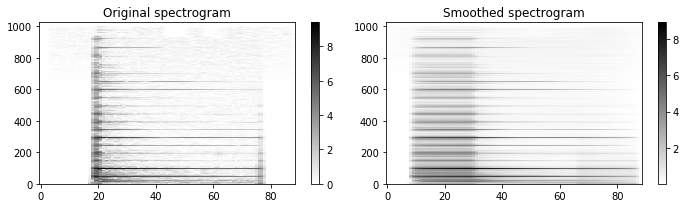

In [1]:
import os
import numpy as np
import librosa
from matplotlib import pyplot as plt
%matplotlib inline

fn_wav = os.path.join('..', 'data', 'B', 'FMP_B_Note-C4_Piano.wav')
x, Fs = librosa.load(fn_wav, sr=None)
X = librosa.stft(x)
Y = np.abs(X)

def spectrogram_average_filter_naive(Y, filter_len):
    K, N = Y.shape
    filter_left = filter_len // 2
    filter_right = filter_len - filter_left - 1
    Y_pad = np.concatenate((np.zeros((K, filter_left)), Y, 
                            np.zeros((K, filter_right))), axis=1)
    Y_new = np.empty_like(Y)
    for k in range(K):
        for n in range(N):
            Y_new[k, n] = Y_pad[k, n:n+filter_len].sum() / filter_len
    return Y_new

filter_length = 21
Y_filt = spectrogram_average_filter_naive(Y, filter_length)

plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.imshow(np.log(1 + 100 * Y), aspect='auto', origin='lower', cmap='gray_r')
plt.title('Original spectrogram')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(np.log(1 + 100 * Y_filt), aspect='auto', origin='lower', cmap='gray_r')
plt.title('Smoothed spectrogram')
plt.colorbar()
plt.tight_layout()

Using the same function we use the `jit`-decorator to compile it. In the following code, we check that the outputs of the resulting function is the same as before and then report on the runtime.

In [2]:
from numba import jit
import timeit

@jit(nopython=True)
def spectrogram_average_filter_jit(Y, filter_len):
    K, N = Y.shape
    
    filter_left = filter_len // 2
    filter_right = filter_len - filter_left - 1

    Y_pad = np.concatenate((np.zeros((K, filter_left)), Y, 
                            np.zeros((K, filter_right))), axis=1)    
    Y_new = np.empty_like(Y)
    
    for k in range(K):
        for n in range(N):
            Y_new[k, n] = Y_pad[k, n:n+filter_len].sum() / filter_len
            
    return Y_new

filter_length = 21
Y_filt_naive = spectrogram_average_filter_naive(Y, filter_length)
Y_filt_jit = spectrogram_average_filter_jit(Y, filter_length)
assert np.allclose(Y_filt_naive, Y_filt_jit)

execuctions = 3
time_nai = timeit.timeit(lambda: spectrogram_average_filter_naive(Y, filter_length), 
                         number=execuctions) / execuctions
time_jit = timeit.timeit(lambda: spectrogram_average_filter_jit(Y, filter_length), 
                         number=execuctions) / execuctions
print('Runtime for naive implementation: %7.5f seconds' % time_nai)
print('Runtime for jit implementation:   %7.5f seconds' % time_jit)

# An alternative for measuring running time:
# %timeit spectrogram_average_filter_naive(Y, filter_length)
# %timeit spectrogram_average_filter_jit(Y, filter_length)

Runtime for naive implementation: 0.25505 seconds
Runtime for jit implementation:   0.00343 seconds


## Parellel Computing

On a standard computer, this the `jit`-compiled function may be about 100 times faster then the original one. With multiple CPU cores, one can obtain further accelerations by parallelizing the loops.

In [3]:
import numba
from numba import jit, prange

@jit(nopython=True, parallel=True)
def spectrogram_average_filter_parallel(Y, filter_len):
    K, N = Y.shape
    filter_left = filter_len // 2
    filter_right = filter_len - filter_left - 1
    Y_pad = np.concatenate((np.zeros((K, filter_left)), Y, 
                            np.zeros((K, filter_right))), axis=1)
    Y_new = np.empty_like(Y)
    for k in prange(K):
        for n in prange(N):
            Y_new[k, n] = Y_pad[k, n:n+filter_len].sum() / filter_len
    return Y_new

filter_length = 21
Y_filt_naive = spectrogram_average_filter_naive(Y, filter_length)
Y_filt_jit = spectrogram_average_filter_jit(Y, filter_length)
Y_filt_parallel = spectrogram_average_filter_parallel(Y, filter_length)
assert np.allclose(Y_filt_naive, Y_filt_parallel)

execuctions=3
time_nai = timeit.timeit(lambda: spectrogram_average_filter_naive(Y, filter_length), 
                         number=execuctions) / execuctions
time_jit = timeit.timeit(lambda: spectrogram_average_filter_jit(Y, filter_length), 
                         number=execuctions) / execuctions
time_par = timeit.timeit(lambda: spectrogram_average_filter_parallel(Y, filter_length), 
                         number=execuctions) / execuctions

num_threads = numba.config.NUMBA_DEFAULT_NUM_THREADS

print('Runtime for naive implementation:                        %7.5f seconds' % time_nai)
print('Runtime for jit implementation:                          %7.5f seconds' % time_jit)
print('Runtime for parallel implementation (using %d threads):   %7.5f seconds' % (num_threads, time_par))

Runtime for naive implementation:                        0.25353 seconds
Runtime for jit implementation:                          0.00332 seconds
Runtime for parallel implementation (using 4 threads):   0.00081 seconds


## Loop-Based vs. Matrix-Based Implemetation

The function implements the smoothing filter as a naive double-nested look. When using packages like NumPy, it is often much more efficient to use matrix operations while avoiding loop structures. Still the `jit`-compiled versions may be a bit faster.

In [4]:
def spectrogram_average_filter_matrix(Y, filter_len):
    K, N = Y.shape
    filter_left = filter_len // 2
    filter_right = filter_len - filter_left - 1
    Y_pad = np.concatenate((np.zeros((K, filter_left)), Y, np.zeros((K, filter_right))), axis=1)
    Y_new = np.empty_like(Y)
    for n in range(N):
        Y_new[:, n] = np.mean(Y_pad[:, n:n+filter_len], axis=1)
    return Y_new

filter_length = 21
Y_filt_naive = spectrogram_average_filter_naive(Y, filter_length)
Y_filt_jit = spectrogram_average_filter_jit(Y, filter_length)
Y_filt_parallel = spectrogram_average_filter_parallel(Y, filter_length)
Y_filt_matrix = spectrogram_average_filter_matrix(Y, filter_length)
assert np.allclose(Y_filt_naive, Y_filt_matrix)

execuctions = 3
time_naive = timeit.timeit(lambda: spectrogram_average_filter_naive(Y, filter_length), 
                           number=execuctions) / execuctions
time_jit = timeit.timeit(lambda: spectrogram_average_filter_jit(Y, filter_length), 
                         number=execuctions) / execuctions
time_par = timeit.timeit(lambda: spectrogram_average_filter_parallel(Y, filter_length), 
                         number=execuctions) / execuctions
time_mat = timeit.timeit(lambda: spectrogram_average_filter_matrix(Y, filter_length), 
                         number=execuctions) / execuctions

num_threads = numba.config.NUMBA_DEFAULT_NUM_THREADS

print('Runtime for naive implementation:                        %7.5f seconds' % time_nai)
print('Runtime for jit implementation:                          %7.5f seconds' % time_jit)
print('Runtime for parallel implementation (using %d threads):   %7.5f seconds' % (num_threads, time_par))
print('Runtime for matrix implementation:                       %7.5f seconds' % time_mat)

Runtime for naive implementation:                        0.25353 seconds
Runtime for jit implementation:                          0.00332 seconds
Runtime for parallel implementation (using 4 threads):   0.00081 seconds
Runtime for matrix implementation:                       0.00428 seconds


##  Deviations from Python Semantics

Note that **not all features** of Python and Numpy are available when compiling with Numba, see the list of [supported Python features](https://numba.pydata.org/numba-doc/dev/reference/pysupported.html) and the list of [supported NumPy features](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html) for more details. For example, we cannot `jit`-compile the last version of our function `spectrogram_average_filter_matrix` due to the keyword `axis` used in the function `mean`.

In [5]:
@jit(nopython=True)
def spectrogram_average_filter_matrixJit(Y, filter_len):
    K, N = Y.shape
    
    filter_left = filter_len // 2
    filter_right = filter_len - filter_left
    
    Y_pad = np.concatenate((np.zeros((K, filter_left)), Y, np.zeros((K, filter_right))), axis=1)
    Y_new = np.empty_like(Y)
    
    for n in range(K):
        Y_new[:, n] = np.mean(Y_pad[:, n:n+filter_len], axis=1)
            
    return Y_new

try:
    Y_filt_matrixJit = spectrogram_average_filter_matrixJit(Y, 12)
except Exception as ex:
    print('Got a %s because of an unsupported numpy feature in numba.' % type(ex).__name__)

Got a TypingError because of an unsupported numpy feature in numba.


In particular, the usage of data types that are determined during runtime may cause unexpected errors. In the following, we give some examples, which work for usual Python functions, but cause problems when using `jit`:


* The command `np.zeros([n, n])` does not work when using `jit`. It needs to be replaced by   `np.zeros((n, n))`.
* `axis` keyword in numpy function $\leadsto$ loop
* optional argument used as index (argument `arg=None`) $\leadsto$ use different variable name inside function
* binary masking for multidimensional arrays $\leadsto$ loop over indexes

In [6]:
def matrix_zeros_nojit(n=5):
    result1 = np.zeros([n, n])
    result2 = np.zeros((n, n), 'int')
    result3 = np.zeros((n, n)).astype('int')
    return result1, result2, result3

@jit(nopython=True)
def matrix_zeros_jit(n=5):
    result1 = np.zeros((n, n))
    result2 = np.zeros((n, n), np.int64)
    result3 = np.zeros((n, n)).astype(np.int32)
    return result1, result2, result3


def average_axis0_nojit(x):
    result = np.mean(x, axis=0)
    return result

@jit(nopython=True)
def average_axis0_jit(x):
    result = np.empty(x.shape[1])
    for i in range(x.shape[1]):
        result[i] = np.mean(x[:, i])
    return result


def optional_arg_nojit(x, idx=None):
    x = np.arange(3)
    if idx is None:
        idx = np.argmin(x)
    return x[idx]

@jit(nopython=True)
def optional_arg_jit(x, idx=None):
    if idx is None:
        _idx = np.argmin(x)
    else:
        _idx = idx
    return x[_idx]

def treshold_nojit(x, tresh):
    x = x.copy()
    x[x > tresh] = 0
    return x

@jit(nopython=True)
def treshold_jit(x, tresh):
    x = x.copy()
    for idx1, idx2 in zip(*np.where(x > tresh)):
        x[idx1, idx2] = 0.0
    return x

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a> and <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div>

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>